# 1. Import The Library That We Need

On this project, I'm using face detector from YuNet to recognizing the face structure before Classifying it. On the first project of face expression recognition, I'm using the entire image to classifying the face expression and the result is not that good because to many area that use for training the network. So this project use another approach in hope to increase the network capabilitiy so that the result can be much more reliable then the first one.

In [1]:
import numpy as np
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from PIL import Image
import pandas as pd
import os
import cv2

os_separator = os.sep

import sys, shutil

In [2]:
train_dir = r'.\\images\\train'
val_dir = r'.\\images\\val'
test_dir = r'.\\images\\test'

# 2. Extracting Faces from the training Image

First step that I use on this project is to extract all faces from the dataset that I provide. This part implementing YuNet to recognize the faces and take the part of the face then write the faces to the new repository so that I shouldn't have to reextracting the faces again if I retrain the network. The dataset that I use on this project is from Google Image. I use selenium for Mining it and I'm not explaining the mining process further on this one.

### **a. Face Detector Function**

In [40]:
def face_detection(img_path):
    # face detector
    detector = cv2.FaceDetectorYN.create(
                        "model/yunet_model.onnx",
                        "",
                        (150, 150),
                        0.8,
                        0.4,
                        5000
                    )
    detector.setInputSize((150, 150))

    # setting up input image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (150, 150))
    (w, h) = img.shape[:2]
    
    # detecting
    face = detector.detect(img)

    # tentuin bagian wajah
    if face[1] is not None:
        koor = abs(face[1][0].astype(int))
        (startX, startY), (endX, endY) = (koor[0], koor[1]), (koor[0]+koor[2], koor[1]+koor[3])
        face = img[startY:endY, startX:endX]
    else:
        face = None
        
    return face

### **b. Extracting all the Image dir from the dataset directory**

In [98]:
# get all files using path perform
extenstions = ['.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG']
def get_listfile(dir):
    list_file = []
    for root, directories, filenames in os.walk(dir):
        for filename in filenames:
            if any(ext in filename for ext in extenstions):
                filepath = os.path.join(root, filename)

                if os.path.exists(filepath): # checking if path exist
                    list_file.append(filepath)
                else: 
                    print(filepath)
    return list(list_file)

In [99]:
train_path = get_listfile(train_dir)
val_path = get_listfile(val_dir)
test_path = get_listfile(test_dir)

### **c. Extracting all faces from training, testing, and validating dataset**

In [108]:
class_names = ['angry', 'confused', 'contemp', 'crying', 'disgust', 'sadness', 'smile']

In [125]:
dataset_path = './data_faces/train'

# Delete datasets Path and create again to clear data when running again
if os.path.exists(dataset_path):
    shutil.rmtree(dataset_path)
    os.makedirs(dataset_path)


for l in train_path:
    face     = face_detection(l) # Detect face
    sep_name = l.split(os_separator)
    if face is not None:
        name   = sep_name[-2].split()[0]
        folder = dataset_path+os_separator+name
        
        # Create folder if does not exist
        if os.path.exists(folder) == False:
            os.makedirs(folder)
        cv2.imwrite(folder+os_separator+sep_name[-1], face)
print('Cropping face done, Check folder'+dataset_path)

Cropping face done, Check folder./data_faces/train


In [126]:
dataset_path = './data_faces/val'

# Delete datasets Path and create again to clear data when running again
if os.path.exists(dataset_path):
    shutil.rmtree(dataset_path)
    os.makedirs(dataset_path)


for l in val_path:
    face     = face_detection(l) # Detect face
    sep_name = l.split(os_separator)
    if face is not None:
        name   = sep_name[-2].split()[0]
        folder = dataset_path+os_separator+name
        
        # Create folder if does not exist
        if os.path.exists(folder) == False:
            os.makedirs(folder)
        cv2.imwrite(folder+os_separator+sep_name[-1], face)
print('Cropping face done, Check folder'+dataset_path)

Cropping face done, Check folder./data_faces/val


In [127]:
dataset_path = './data_faces/test'

# Delete datasets Path and create again to clear data when running again
if os.path.exists(dataset_path):
    shutil.rmtree(dataset_path)
    os.makedirs(dataset_path)


for l in test_path:
    face     = face_detection(l) # Detect face
    sep_name = l.split(os_separator)
    if face is not None:
        name   = sep_name[-2].split()[0]
        folder = dataset_path+os_separator+name
        
        # Create folder if does not exist
        if os.path.exists(folder) == False:
            os.makedirs(folder)
        cv2.imwrite(folder+os_separator+sep_name[-1], face)
print('Cropping face done, Check folder'+dataset_path)

Cropping face done, Check folder./data_faces/test


# 3. Training The Network

Next process is to train the network with the face dataset that extracted before. This step included preprocessing and augmenting the face dataset with Tensorflow Image Data Generator, generating and compiling the network. The network uses MISH as activation function and Crossentropy as loss function. This is to test the MISH function if it can resulting better than ReLU. More over, the network uses Rectified Adam for optimizing the result while training.

### **a. Reading The Face Data, Pre-Processing, and Augmenting It**

In [2]:
train_dir = r'.\\data_faces\\train'
val_dir = r'.\\data_faces\\val'
test_dir = r'.\\data_faces\\test'

In [3]:
# iamge data generator

train_gen = ImageDataGenerator(rescale=1./255,
                             horizontal_flip=True,
                             brightness_range= (0.40, 0.8),
                             zoom_range=0.1,
                             fill_mode='nearest')

val_gen = ImageDataGenerator(rescale=1./255,
                             horizontal_flip=True,
                             brightness_range= (0.40, 0.7),
                             zoom_range=0.1,
                             fill_mode='nearest')

test_gen = ImageDataGenerator(rescale=1./255,
                             fill_mode='nearest')

In [17]:
# build image data gen

train_data = train_gen.flow_from_directory(train_dir,
                                            batch_size=32,
                                            target_size=(64, 64), 
                                            class_mode='categorical')

val_data = val_gen.flow_from_directory(val_dir,
                                        batch_size=32,
                                        target_size=(64, 64),
                                        class_mode='categorical')

test_data = test_gen.flow_from_directory(test_dir,
                                        batch_size=32,
                                        target_size=(64, 64),
                                        class_mode='categorical')

Found 3486 images belonging to 7 classes.
Found 1157 images belonging to 7 classes.
Found 1159 images belonging to 7 classes.


### **b. Constructing and Compiling The Network**

In [18]:
# creating checkpoints for callback
checkpoint_dir = r'.\\ckpt_bener\\Nvidia002'
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_dir,
                                                    save_weight_only=False,
                                                    mode='max',
                                                    monitor='val_accuracy',
                                                    save_best_only=True,
                                                    verbose=0)

In [19]:
# model architecture
model = tf.keras.models.Sequential(
    [
    tf.keras.layers.Conv2D(128, (3,3), input_shape=(64, 64, 3), activation=tfa.activations.mish, padding='same'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(32, (3,3), activation=tfa.activations.mish, padding='same'), #1
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(16, (3,3), activation=tfa.activations.mish, padding='same'),  #2
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation=tfa.activations.mish),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(16, activation=tfa.activations.mish),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(7, activation='softmax')
    ]
)

model.compile(loss='categorical_crossentropy',
            optimizer=tfa.optimizers.RectifiedAdam(0.005),
            metrics=[
                    'accuracy',
                    tf.keras.metrics.Precision(name="precision"),
                    tf.keras.metrics.Recall(name="recall"),
                    tf.keras.metrics.AUC(name="auc"),
                    tf.keras.metrics.AUC(name="prc", curve="PR"),
                ])

### **c. Training The Model**

In [ ]:
model.fit(train_data,
            epochs=500,
            validation_data=val_data,
            callbacks=[cp_callback],
            verbose=1)

### **d. Checking Training Result**

In [21]:
history = model.history

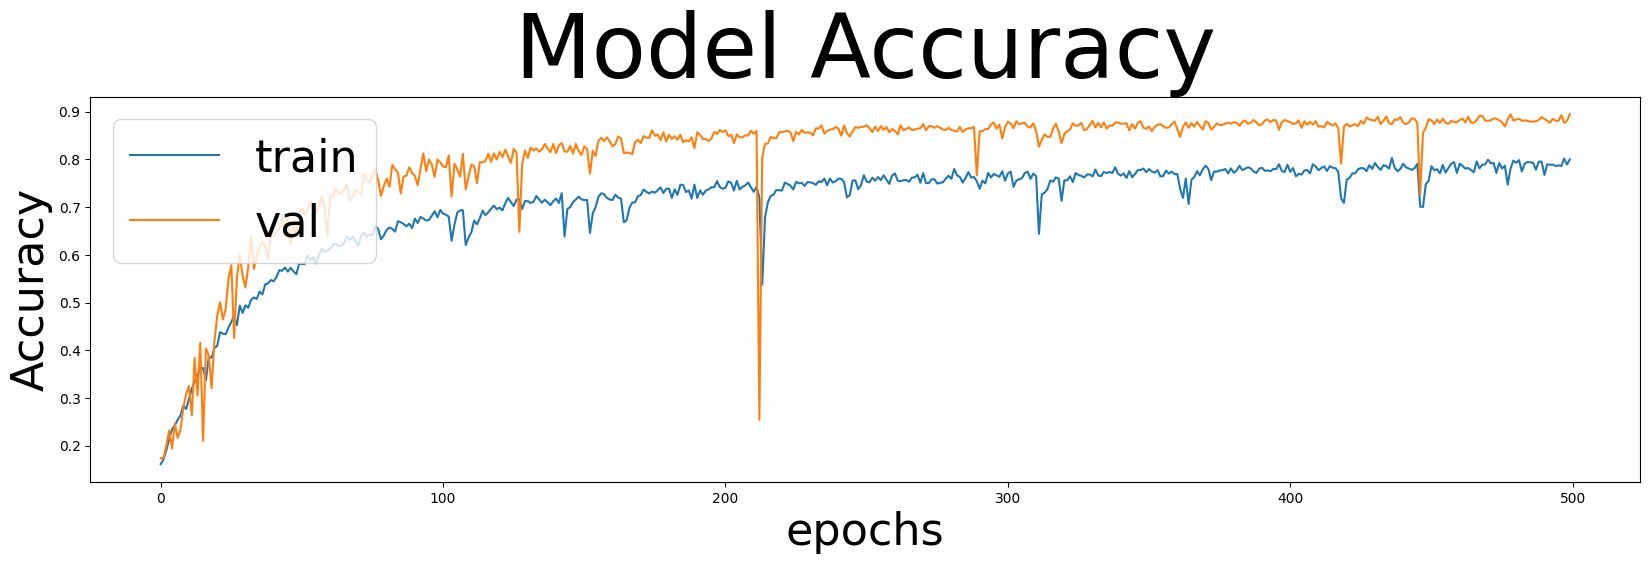

In [22]:
plt.figure(figsize=(20, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train', 'val'], loc='upper left', prop={'size':32})
plt.ylabel('Accuracy', fontsize=32)
plt.xlabel('epochs', fontsize=32)
plt.title('Model Accuracy', fontsize=64)
plt.show()

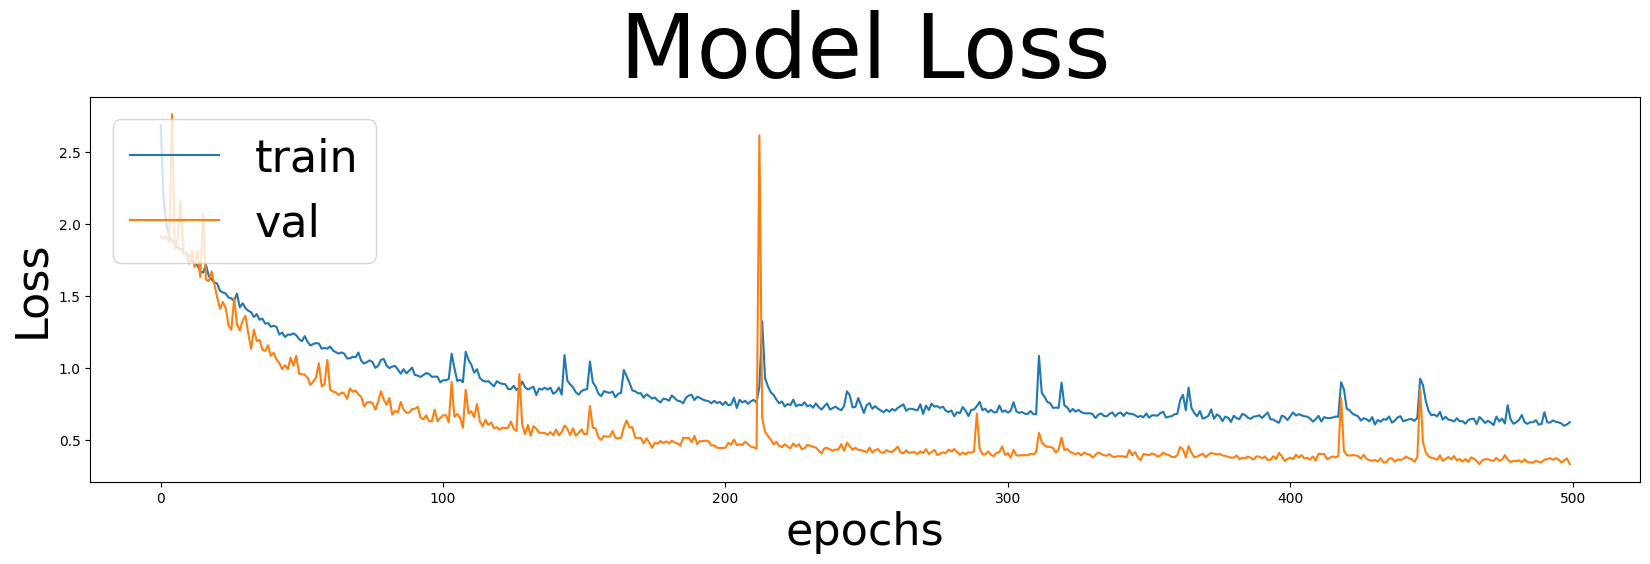

In [23]:
plt.figure(figsize=(20, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'val'], loc='upper left', prop={'size':32})
plt.ylabel('Loss', fontsize=32)
plt.xlabel('epochs', fontsize=32)
plt.title('Model Loss', fontsize=64)
plt.show()

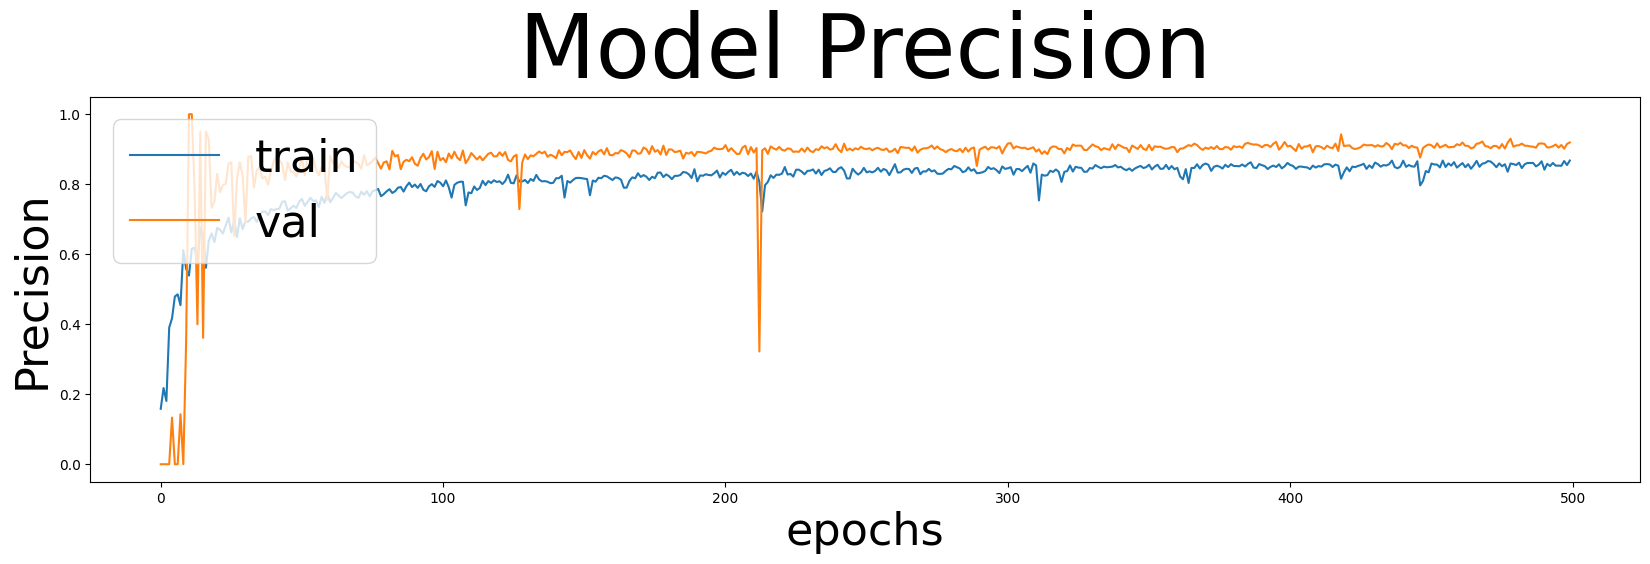

In [24]:
plt.figure(figsize=(20, 5))
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.legend(['train', 'val'], loc='upper left', prop={'size':32})
plt.ylabel('Precision', fontsize=32)
plt.xlabel('epochs', fontsize=32)
plt.title('Model Precision', fontsize=64)
plt.show()

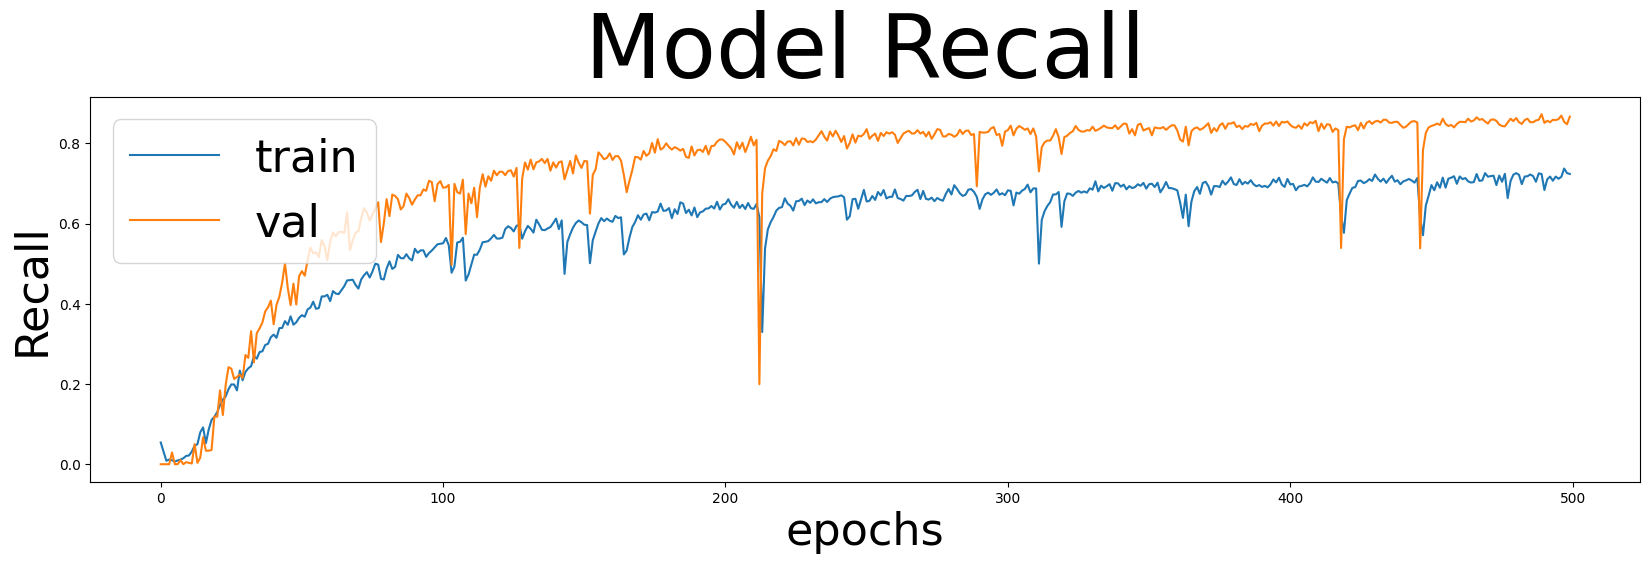

In [25]:
plt.figure(figsize=(20, 5))
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.legend(['train', 'val'], loc='upper left', prop={'size':32})
plt.ylabel('Recall', fontsize=32)
plt.xlabel('epochs', fontsize=32)
plt.title('Model Recall', fontsize=64)
plt.show()

### **e. Testing The Network**

In [26]:
# Predicting the test dataset

y_pred = model.predict(test_data)

37/37 [==============================] - 18s 491ms/step


In [27]:
# Convert the predict result

y_pred = y_pred.argmax(axis=-1)

In [28]:
# taking the true label from test data generator

y_test = test_data.labels

In [29]:
y_test = np.array(y_test)
y_pred = np.array(y_pred)

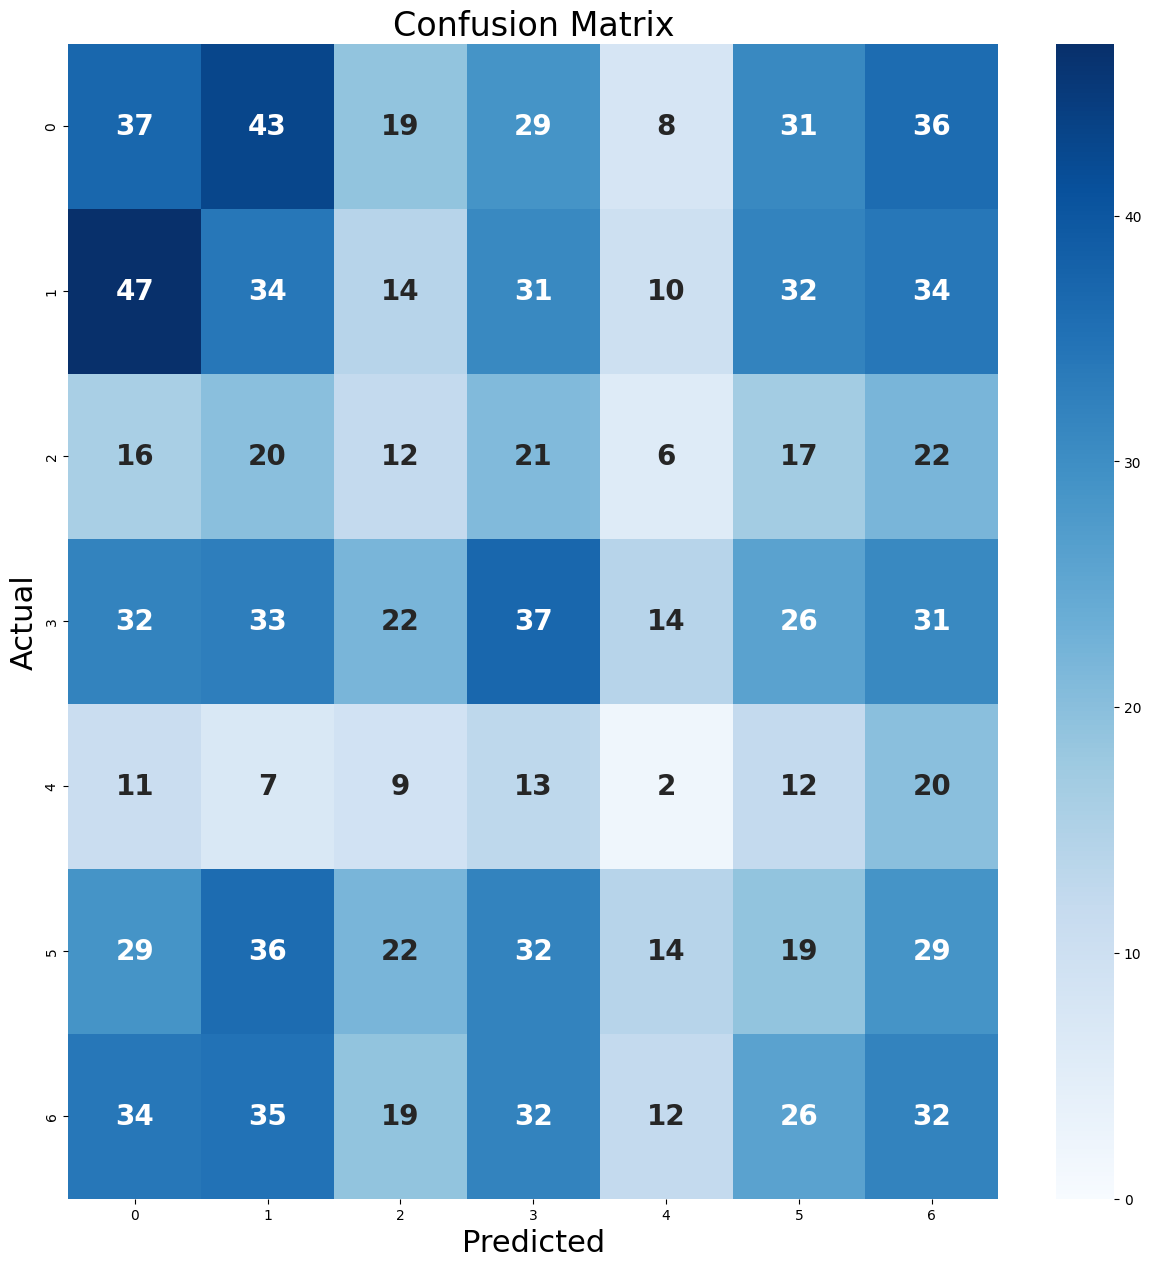

In [30]:
# Building the confusion matrix from predicting and true label

from sklearn.metrics import confusion_matrix
import seaborn as sns

class_names = ['angry', 'confused', 'contemp', 'crying', 'disgust', 'sadness', 'smile']
cf = confusion_matrix(y_pred=y_pred, y_true=y_test)

plt.figure(figsize=(15, 15))
sns.heatmap(cf, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=True, annot_kws={
                'fontsize': 20,
                'fontweight': 'bold'
            }) 
'''plt.xticks(np.arange(len(class_names))+.5, class_names, rotation= 90, fontsize=14)
plt.yticks(np.arange(len(class_names))+.5, class_names, rotation=0, fontsize=14)'''
plt.xlabel("Predicted", fontsize=22)
plt.ylabel("Actual", fontsize=22)
plt.title("Confusion Matrix", fontsize=24)
plt.show()

In [33]:
# Evaluating the network with test data

loss, accuracy, precision, recall, auc, prc = model.evaluate(test_data)

37/37 [==============================] - 2s 38ms/step - loss: 0.3423 - accuracy: 0.9068 - precision: 0.9247 - recall: 0.9008 - auc: 0.9856 - prc: 0.9568


In [37]:
print("Model Evaluation")
print("model accuracy\t\t: ", accuracy)
print('model precision\t\t: ', precision)
print('model recall\t\t: ', recall)
print('model loss\t\t: ', loss)

Model Evaluation
model accuracy		:  0.9068162441253662
model precision		:  0.9247121214866638
model recall		:  0.9007765054702759
model loss		:  0.3423389196395874


# Testing Trained Network With Random Data

### **a. Detecting the image face**

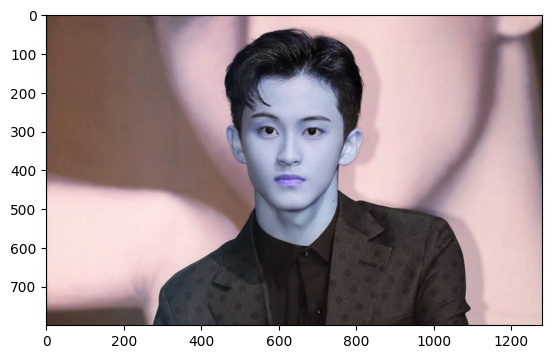

In [49]:
img_test = cv2.imread('0001.jpg')
plt.imshow(img_test)

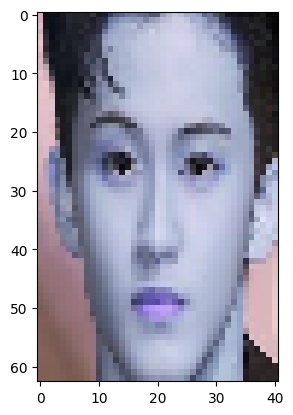

In [54]:
face_test = face_detection('0001.jpg')
plt.imshow(face_test)

### **b. Pre-Processing the image face**

In [56]:
face_test = cv2.resize(face_test, (64, 64))
face_test.shape

(64, 64, 3)

In [59]:
face_array = tf.keras.utils.img_to_array(face_test)
face_dims = tf.expand_dims(face_array, axis=0)

In [61]:
from tensorflow.keras.applications.resnet50 import preprocess_input

img_test_array = preprocess_input(face_dims)

### **c. Predicting the image face expression**

In [62]:
t_res = model.predict(img_test_array)

1/1 [==============================] - 1s 542ms/step


In [63]:
t_res.argmax(axis=-1)

array([4], dtype=int64)

In [64]:
score = tf.nn.softmax(t_res)

In [65]:
score

<tf.Tensor: shape=(1, 7), dtype=float32, numpy=
array([[0.1147015 , 0.1147015 , 0.1147015 , 0.1147015 , 0.31179097,
        0.1147015 , 0.1147015 ]], dtype=float32)>

### **d. Plotting the predicting result**

This image most likely belongs to disgust with a 31.18 percent confidence.


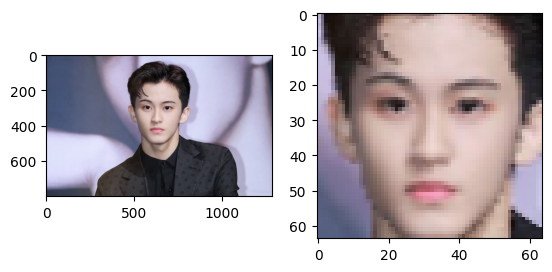

In [84]:
import matplotlib.pyplot as plt
import numpy as np

class_names = ['angry', 'confused', 'contemp', 'crying', 'disgust', 'sadness', 'smile']
img_test = cv2.imread('0001.jpg')

img_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)
face_test = cv2.cvtColor(face_test, cv2.COLOR_BGR2RGB)

#plt.figure(figsize=(300, 100))
fig, ax = plt.subplots(nrows=1, ncols=2)

ax[0].imshow(img_test)
ax[1].imshow(face_test)


print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[int(t_res.argmax(axis=-1))], 100 * np.max(score))
)

# Plottting The Network Structure

In [3]:
model = tf.keras.models.load_model('ckpt_bener/Nvidia002')

In [4]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 64, 64, 128)       3584      
                                                                 
 dropout_25 (Dropout)        (None, 64, 64, 128)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 64, 64, 32)        36896     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 dropout_26 (Dropout)        (None, 32, 32, 32)        0         
                                                                 
 conv2d_17 (Conv2D)          (None, 32, 32, 16)        4624      
                                                      

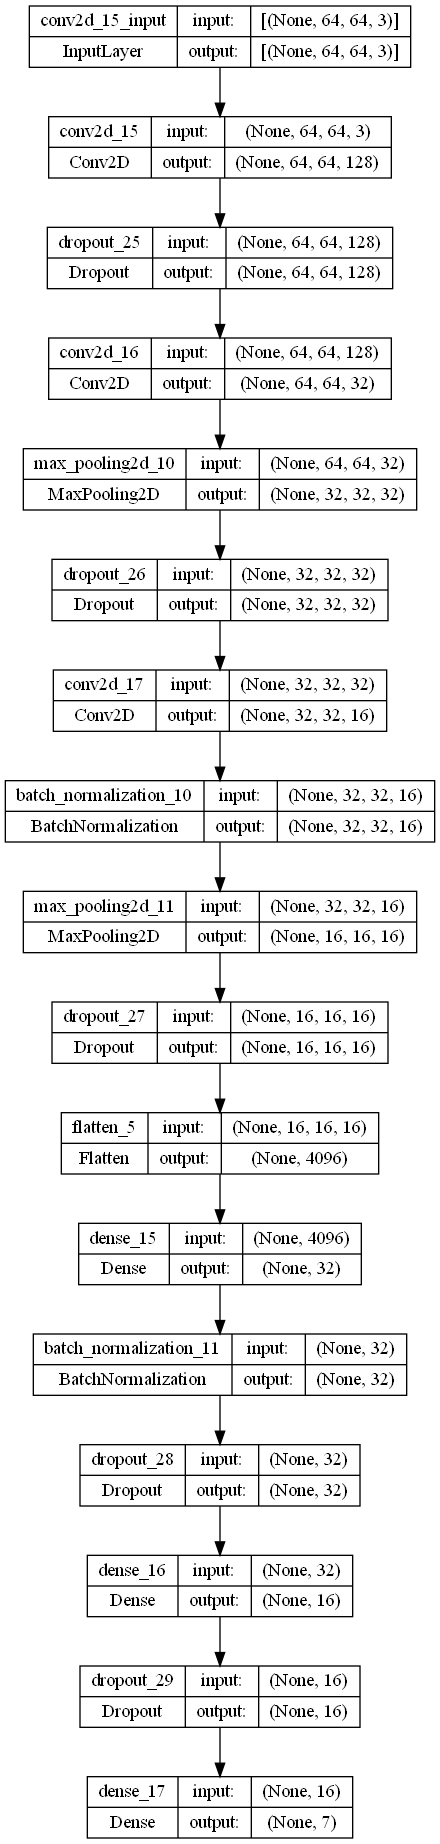

In [8]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir='TB')